# BCBGSO Fall 2018 Advanced Python Workshop

## Section 3: scikit-learn 

scikit-learn is a Python library that provides a wide range of machine learning algorithms.  It has several dependencies that must be installed before being used, but if you've installed Anaconda, you should be good to go.

### Section 3.1: Reading in data

scikit-learn comes with many submodules.  The first one we'll be using is the `datasets` submodule that comes with preprocessed data for us to use.  We'll begin with the [Optical Recognition of Handwritten Digits](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) data set.  This data set is a collection of 8 x 8 grayscale pixel images representing handwritten digits.  The aim of performing machine learning on this data set is to learn what digit each image represents.

In [2]:
from sklearn import datasets
digits = datasets.load_digits()


Before we get started with prediction, let's learn a little bit more about our digits dataset.  We begin with figuring out what data structure it is:

In [6]:
type(digits)

sklearn.utils.Bunch

The documentation for `Bunch` is kind of a pain to find.  However, we can find the available methods for a `Bunch` object by using `dir`:

In [7]:
dir(digits)

['DESCR', 'data', 'images', 'target', 'target_names']

You can access each of the values for each attribute by typing `digits.<attribute>`.  Go ahead and figure out what each of these attributes represent.  Use the `.shape` method from `numpy` to learn more about each attribute.

Let's separate the data, images, and targets into separate objects and inspect their shapes.

In [19]:
digits_data = digits.data
digits_data.shape

(1797, 64)

In [20]:
digits_target = digits.target
digits_target.shape

(1797,)

In [23]:
digits_images = digits.images
digits_images.shape

(1797, 8, 8)

Let's visualize `digits_images`:

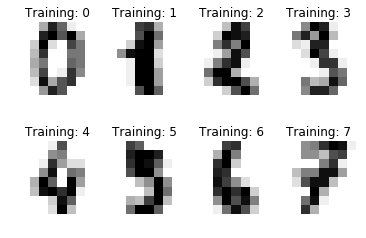

In [27]:
%matplotlib inline
import matplotlib.pyplot as plot
image_label_list = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(image_label_list[:8]):
    plot.subplot(2, 4, index + 1)
    plot.axis('off')
    plot.imshow(image, cmap = plot.cm.gray_r, interpolation = 'nearest')
    plot.title('Training: ' + str(label))

### Exercise 3.1
 
1. What do `digits_data`, `digits_target`, and `digits_images` represent?

## Section 3.2: Making predictions

We will be using a classification algorithm to predict which digit each image represents.  There are several algorithms we can use for this particular data set, but today, we will be using the [K-Means algorithm](https://en.wikipedia.org/wiki/K-means_clustering).  The K-Means algorithm works by classifying our inputs into K different clusters (the value of K is provided by the user).  Briefly, the algorithm randomly positions k centroids in the data space; then, each point in the data set is assigned to the cluster signified by the nearest centroid.  Afterwards, the location of the centroid is recalculated to be the centroid of its assigned data points.  As the algorithm repeats, the cluster membership stabilizes.

Before we actually use the algorithm, we have some preprocessing to do.  We will first scale (normalize) the data so that it has a mean of 0 and a standard deviion of one.  

In [28]:
from sklearn.preprocessing import scale
data = scale(digits.data)

We'll now separate the data into a *training* set and a *testing* set.  The purpose of this is to assess our predictor's performance - after teaching the algorithm how to distinguish digits on the training set, we will then have it classify the digits in the testing set to evaluate how effective a predictor it is.  If it is doing poorly, we can return the parameters of the algorithm and attempt to improve its performance.  

We'll use the `train_test_split` function of the `sklearn.model_selection` module to split our data. We'll have 0.25 of our data be the test data, and we'll use a random seed for reproducibility. 

In [32]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, images_train, images_test = train_test_split(
        data, digits.target, digits.images, test_size = 0.25, random_state = 489)


In [33]:
x_train.shape

(1347, 64)

In [34]:
x_test.shape

(450, 64)

So we see that there are exactly 2/3 of our original data in the training set and the remaing 1/3 in the testing set.  We're now ready to train the K means predictor.  

In [66]:
from sklearn import cluster

k_means_predictor = cluster.KMeans(n_clusters = 10, random_state = 489)

k_means_predictor.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=489, tol=0.0001, verbose=0)

Here, `n_clusters` is how many clusters we want to separate the data into, and thus, the number of centroids we will begin with.  Because we're identifying handwritten digits, we want one cluster for each value.  Look up the documentation for `cluster.KMeans` to learn about `n_init` and `tol`.

Let's visualize what the centroids for each cluster are:

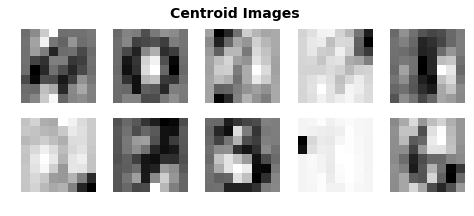

In [67]:
fig = plot.figure(figsize=(8, 3))
fig.suptitle('Centroid Images', fontsize = 14, fontweight = 'bold')

for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i)
    ax.imshow(k_means_predictor.cluster_centers_[i].reshape((8, 8)), cmap = plot.cm.binary)
    plot.axis('off')

What do you think?

We'll now test how accurate our predictor is:

In [73]:
y_pred_k_means = k_means_predictor.predict(x_test)

The above line used the model that we trained on the `x_train` data set to predict the labels of the `x_test` data set.  We can evaluate the performance with a confusion matrix.  We're going to borrow scikit-learn's `plot_confusion_matrix` function here:

In [74]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

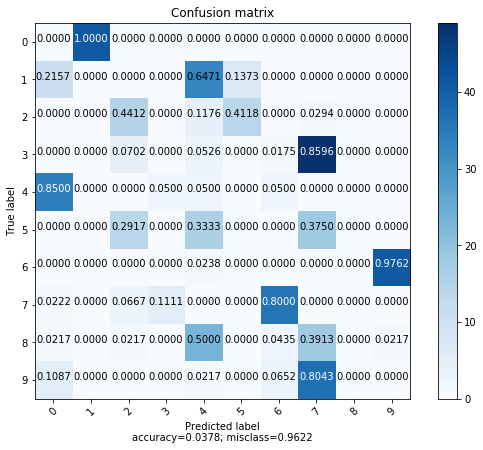

In [75]:
from sklearn.metrics import confusion_matrix


labels = [i for i in range(10)]
k_means_cm = confusion_matrix(y_test, y_pred_k_means, labels)

    
plot_confusion_matrix(k_means_cm, labels)

What is being shown here?  Do you think this model is doing a good job?  What was our first hint that something wasn't right here?

### Section 3.3: Another algorithm

The K-Means algorithm wasn't a great choice.  But which one should we use?  scikit-learn has an [algorithm roadmap](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to help us decide which algorithm to use:

![alt-text](images/ml_map.png)

According to this roadmap, the first algorithm we should try is a linear SVC, or SVM.  Since we already have our data preprocessed and split into training and testing data sets, we can skip straight to training a new predictor:

In [72]:
from sklearn import svm

svm_predictor = svm.SVC(kernel = 'linear')
svm_predictor.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Let's make predictions with our new predictor and check out the performance:

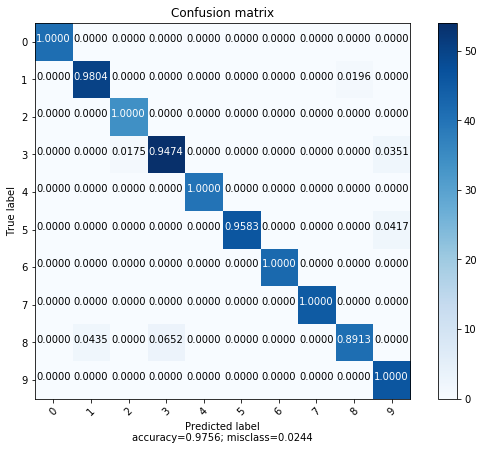

In [81]:
y_pred_svm = svm_predictor.predict(x_test)
svm_cm = confusion_matrix(y_test, y_pred_svm, labels)
plot_confusion_matrix(svm_cm, labels)

Much better!

### Exercise 3.3:

1. Look up the `MLPClassifier` submodule of `sklearn.neural_network` and repeat the above process.  How did it perform?  Can you tune the parameters of the model to improve the performance?
2. Repeat the above process on the iris dataset.

## Section 3.3: More resources

What we gave here today was just a very basic introduction to how to make predictions using scikit-learn.  Here are some additional resources to take the next few steps:

* [3Blue1Brown's excellet series of videos on neural networks](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) is the best place to start.  He does a great job of emphasizing the intuition behind the network without getting bogged down in too much detail.  If you only do one thing to learn more about neural networks, watch these videos.
* [The official scikit-learn tutorials](http://scikit-learn.org/stable/tutorial/index.html) are pretty in-depth and straightforward.a
* [MATLAB's Deep Learning Onramp](https://matlabacademy.mathworks.com/R2018a/portal.html?course=deeplearning) is a great hands-on tutorial for getting you started with machine learning.  The only downside is that it's in MATLAB. 
* If you're ready to start digging into the math behind neural networks, the [Wikipedia entry](https://en.wikipedia.org/wiki/Convolutional_neural_network) is a good place to get a high-level overview.  From there, Bishop's book [Pattern Recognition and Machine Learning](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) is where to go for a more thorough treatment of the material.


[Previous Section: Jupyter](advanced.python.2.ipynb)